# EDA SOBRE ACCIDENTES DE AVIONES.

## DESCRIPCION

Este EDA se realiza como parte del proyecto 02 de la etapa labs para el bootcamp SoyHenry. 

Dicho repositorio se puede encontrar en: https://github.com/soyHenry/PI03-Analytics

Buscamos realizar un trabajo analitico sobre un dataset de accidentes de aviones con el fin de identificar patrones para mejorar la seguridad de la aviacion. 

Para ello, usaremos del dataset que hemos recopalido desde: https://aviation-safety.net/database/

Por si les interesa obtenerlo, se encuentra limpio en: https://github.com/jcamatta/aviation_safety_network_data

## ENFOQUE

Puesto que nos interesa mejorar la seguridad de la aviacion y tenemos data historica, este EDA tendra como enfoque:
- Analizar las distintas causas de los accidentes.
- Conocer los distintos tipos de accidentes.
- Averiguar que patrones se cumplen para cada tipo de accidentes.
- Conocer que tipo de patrones se observan a nivel global y local (es decir, por pais).

## LIBRERIAS USADAS

- pandas
- numpy
- warnings
- pycountry_convert
- sklearn
- spacy
- matplotlib
- seaborn
- wordcloud
- collections

<hr>

## EXPLORATORY DATA ANALYSIS

### IMPORTAMOS LOS DATOS

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../../data/transform/asn_final_v2.csv')
data.shape

(19291, 20)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19291 entries, 0 to 19290
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fecha                   19291 non-null  object 
 1   hora                    8064 non-null   object 
 2   operator                18690 non-null  object 
 3   total_personas          17448 non-null  float64
 4   cant_pasajeros          17449 non-null  float64
 5   cant_tripulantes        17448 non-null  float64
 6   total_fallecidos        17448 non-null  float64
 7   pasajeros_fallecidos    17449 non-null  float64
 8   tripulantes_fallecidos  17448 non-null  float64
 9   pais_accidente          18904 non-null  object 
 10  estado_accidente        18602 non-null  object 
 11  pais_salida             13811 non-null  object 
 12  estado_salida           12807 non-null  object 
 13  pais_destino            14020 non-null  object 
 14  estado_destino          12986 non-null

### FEATURE ENGINEER

Se crean las siguientes columnas:
- hora_minuto = hh:mm del accidente
- hora = hh
- minuto = mm
- parte_del_dia = categoriza segun maniana/tarde/noche segun la hora en la que ocurrio el accidente
<hr>
- year = anio del accidente
- trimestre = trimestre del accidente
- mes = mes del accidente
- dia = dia del accidente
- edad_avion = anios entre el primer vuelo y el accidente
<hr>

- continente = continente del pais donde resulto el accidente
- ruta_pais = pais de salida y pais destino separado por una coma.
- ruta_estado = estado de salida y estado destino separado por una coma.
<hr>

- victimas = true/false si hubo victimas
- ratio = porcentaje de fallecidos respecto del total de personas
- pasajeros_vivos = pasajeros que sobrevivieron
- tripulantes_vivos = tripulantes que sobrevivieron
- total_vivos = total de personas que sobrevivieron
<hr>

- top3_3gram = es el top 3 de 3 n-gram segun el metodo TfidfVectorizer. Resume con 3 tokens mas "frecuentes" de 3 palabras la columna narrative.
- top3_2gram = lo mismo que anterior, pero en este caso cada token esta formado por dos palabras.
- top3_1gram = lo mismo que los anteriores, en este caso un token equivale a una palabra.

In [4]:
data.fecha = pd.to_datetime(data.fecha)

In [5]:
data['hora_minuto'] = data.hora
data['hora'] = data[['hora_minuto']].applymap(lambda x: x.split(':')[0], na_action='ignore')
data['minuto'] = data[['hora_minuto']].applymap(lambda x: x.split(':')[1], na_action='ignore')

In [6]:
notna = data.hora.notna()

intervalos = [-1, 5, 12, 18, 23]
etiquetas = ['Noche', 'Mañana', 'Tarde', 'Noche']
x = pd.cut(data.loc[notna, 'hora'].apply(lambda v: int(v)), bins=intervalos, labels=etiquetas, right=True, ordered=False)

data['parte_del_dia'] = np.nan
data.loc[notna, 'parte_del_dia'] = x

In [7]:
data['year'] = data.fecha.dt.year
data['trimestre'] = data.fecha.dt.quarter
data['mes'] = data.fecha.dt.month
data['dia'] = data.fecha.dt.day_name().str.lower()

In [8]:
# Cambiamos los dias de la semana de ingles al espaniol.

dias_semana = {'saturday': 'sabado','monday': 'lunes','wednesday': 'miercoles',
               'tuesday': 'martes','friday': 'viernes','sunday': 'domingo','thursday': 'jueves'}
data['dia'] = data['dia'].replace(dias_semana)

In [9]:
data['edad_avion'] = data.year - data.primer_vuelo

indice = (data.edad_avion < 0)
data.loc[indice, 'edad_avion'] = np.nan

In [10]:
def obtener_geodata(columna):
    continentes = []
    iso_code = []
    for v in columna:
        try:
            values = country_data.loc[v]
            continente = values.Continent.lower()
            code = values.Code.lower()
        except:
            continente = 'unknown'
            code = 'unknown'
        continentes.append(continente)
        iso_code.append(code)
    return continentes, iso_code

In [11]:
country_data = pd.read_csv('../../data/raw_data/continentes.csv')
country_data = country_data.set_index(country_data.Entity.str.lower())

In [12]:
data.pais_accidente = data.pais_accidente.replace('united states of america', 'united states')
continentes, iso_code = obtener_geodata(data.pais_accidente)

data['continente'] = continentes
data['iso_code'] = iso_code

In [13]:
data['ruta_pais'] = data.pais_salida + '|' + data.pais_destino
data['ruta_estado'] = data.estado_salida + '|' + data.estado_destino

In [14]:
data['victimas'] = True
indice = (data.total_fallecidos == 0)
data.loc[indice, 'victimas'] = False

In [15]:
data['ratio'] = (data.total_fallecidos / data.total_personas)
data['pasajeros_vivos'] = data.cant_pasajeros - data.pasajeros_fallecidos
data['tripulantes_vivos'] = data.cant_tripulantes - data.tripulantes_fallecidos
data['total_vivos'] = data.total_personas - data.total_fallecidos

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

def topn_ngram(columna_texto, topn, ngram_size, token_pattern=r'\b[a-zA-Z]+\b'):
    
    x = columna_texto.fillna('')
    
    # Usamos los stopwords de spacy.
    nlp = spacy.load('en_core_web_sm')
    stop_words = list(nlp.Defaults.stop_words)
    
    # Creaamos instancia de TfidfVectorizer y la ajustamos a los datos
    # El token pattern por defecto ignora los valores numericos.
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_size, stop_words=stop_words, token_pattern=token_pattern)
    tfidf_matrix = tfidf_vectorizer.fit_transform(x)
    feature_names = list(tfidf_vectorizer.vocabulary_.keys())

    output = []
    # Obtenemos y almacenamos los top_n 1-GRAM más comunes para cada fila o narrative.
    for i in range(x.size):

        tfidf_scores = tfidf_matrix[i].toarray().flatten()
        topn_idx = tfidf_scores.argsort()[-topn:][::-1]

        top_n_grams = [feature_names[idx] for idx in topn_idx]

        output.append('|'.join(top_n_grams))
        
    return output

In [17]:
output = topn_ngram(data.narrative, 3, (3, 3))
data['top3_3gram'] = output

output = topn_ngram(data.narrative, 3, (2, 2))
data['top3_2gram'] = output

output = topn_ngram(data.narrative, 3, (1, 1))
data['top3_1gram'] = output

In [18]:
!pip install wordcloud


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


<hr>

### PUESTO EN CONTEXTO

Previo a pasar con el analisis grafico, pongamonos en contexto con una serie de medidas.

Entre *1919* y *2022* ocurrieron un total de 19253 accidentes de los cuales 9707 (50%) provocaron al menos una muerte.

El numero de fallecidos totales por los accidentes aereos es de 115.438 victimas.

Creo que con estos numeros es suficiente para hacerle notar al lector de la problematica subyacente. Espero haber generado la suficiente preocupacion e interes por entender la evolucion historica y actual de los accidentes aereos y en la toma de medidas y practicas mas seguras.

A continuacion, realizaremos una viaje visual a traves del tiempo para entender esta problematica.

<hr>

### ANALISIS

Importamos las librerias de visualizacion

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", palette=None)

A partir de ahora, puesto que 2023 todavia no termino, para evitar modificar los graficos, vamos a trabajar hasta el anio 2022.

In [20]:
data = data[data.year <= 2022]

# Agrupamos los datos por año
year_grouped = data.groupby('year')

#### ANALISIS TEMPORAL

**PREGUNTAS QUE NOS QUERRIAMOS RESPONDER**

- Entender cual es la evolucion historica de los accidentes.

- Que tipo de patrones temporales existen, a saber: tendencial, estacionalidad, valor medio, etc.

In [21]:
# Veamos la ventana temporal
data.year.min(), data.year.max()

(1919, 2022)

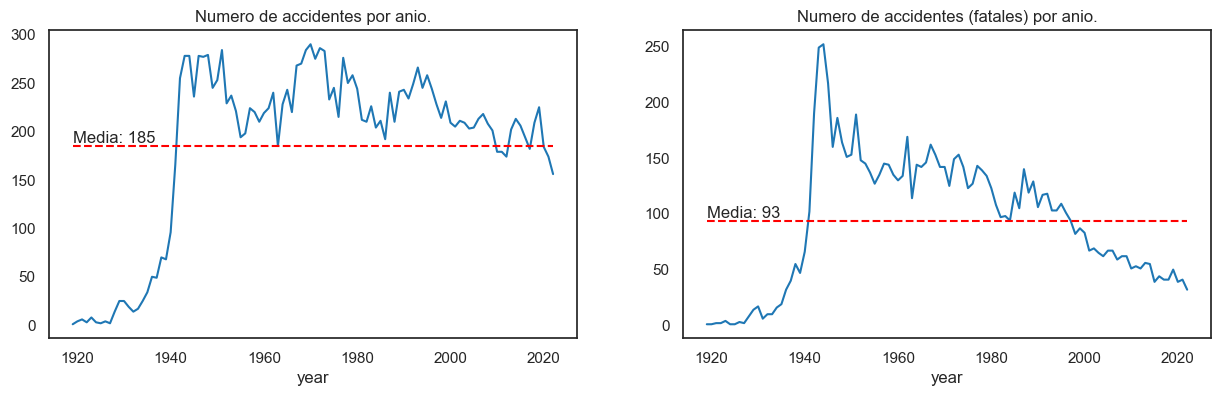

In [22]:
accidentes = year_grouped.victimas.count().values
accidentes_fatales = year_grouped.victimas.sum().values

years = year_grouped.victimas.count().index

# Calculamos el valor medio del numero de accidentes fatales
mean_accidentes = np.zeros(len(years)) + np.mean(accidentes)
mean_accidentes_fatales = np.zeros(len(years)) + np.mean(accidentes_fatales)

lista1 = [accidentes, accidentes_fatales]
lista2 = [mean_accidentes, mean_accidentes_fatales]
# Graficamos
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

for i in range(len(lista1)):
    eje_y = lista1[i]
    mean = lista2[i]
    ax[i].plot(years, eje_y)
    ax[i].plot(years, mean, color='red', linestyle='--')
    
    ax[i].text(years[0], mean[0], f'Media: {mean[0]:.0f}', ha='left', va='bottom')
    ax[i].set_xlabel('year')

ax[0].set_title(f'Numero de accidentes por anio.')  
ax[1].set_title(f'Numero de accidentes (fatales) por anio.')  

plt.show()

Observamos:

- Hubo un pico de accidentes entre 1940 y 1950, quizas debido al periodo de guerra.

- Luego tiene una tendencia descendente hasta el presente.

- El numero promedio de accidentes por anio es de 185.

- El numero promedio de accidentes fatales por año es de 93.

- Lo cual es un numero bastante elevado.

**Notemos que, si bien el numero de accidentes se mantuvo en promedio, si! se redujo el numero de accidentes con fatalidades.**

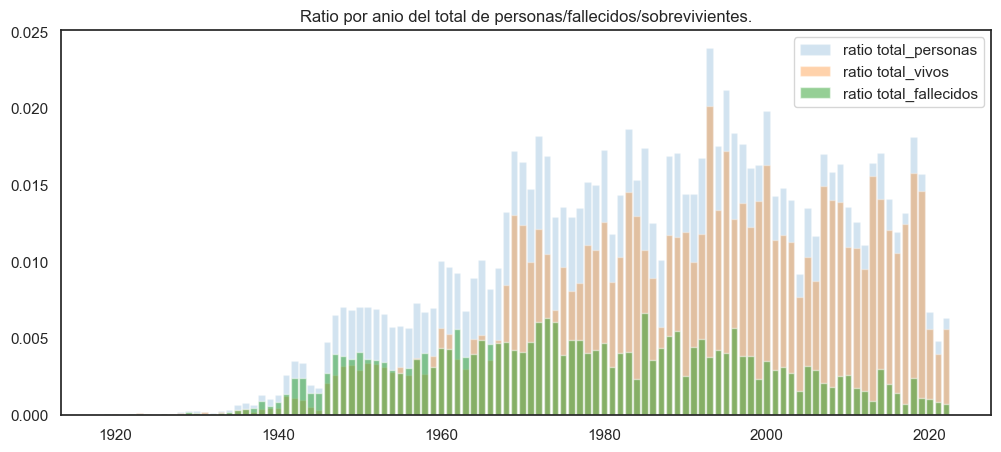

In [23]:
suma_total_personas = data.total_personas.sum()

eje_y = []

fig, ax = plt.subplots(figsize=(12, 5))
i = 0
for c in ['total_personas', 'total_vivos', 'total_fallecidos']:
    # Ratio de total de personas fallecidas/vivas.
    v = year_grouped[c].sum().values / suma_total_personas
    ax.bar(years, v, label=f'ratio {c}', alpha=0.2 + 0.15*i)
    i += 1

ax.legend()
ax.set_title('Ratio por anio del total de personas/fallecidos/sobrevivientes.')
plt.show()

Observamos:

- El numero de de personas involucrada en accidentes fue en aumento desde 1919.
- Sin embargo, el numero total de fallecidos tiene la forma de una parabola hacia abajo, con un decaimento en los ultimos anios.
- Por otro lado, el numero de personas vivas en los accidentes se mantiene relativamente similar al del total de personas.

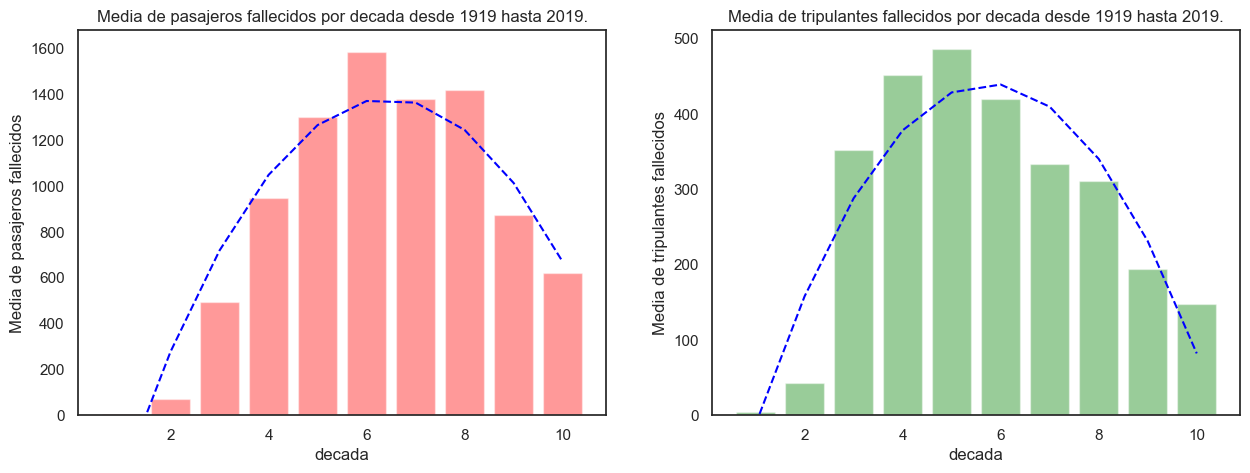

In [24]:
# Veamos como evoluciona el promedio de pasajeros y tripulantes fallecidos por decada

# Calculamos el promedio para cada decada desde 1919 hasta 2019
eje_y = []
eje_z = []
for i in years[::10][:-1]:
    x = range(i, i + 10)
    y = year_grouped.pasajeros_fallecidos.sum()[x].mean()
    z = year_grouped.tripulantes_fallecidos.sum()[x].mean()
    eje_y.append(y)
    eje_z.append(z)

    
x = np.arange(1, 11)
color = ['red', 'green']

# Ajuste de parabola para cada conjunto de datos.
a, b, c = np.polyfit(x, eje_y, 2)
y_parabola = a * x**2 + b * x + c

a, b, c = np.polyfit(x, eje_z, 2)
z_parabola = a * x**2 + b * x + c

heights = [eje_y, eje_z]
parabolas = [y_parabola, z_parabola]    

# Graficamos
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i, c in enumerate(['pasajeros fallecidos', 'tripulantes fallecidos']):
    ax[i].bar(x=x, height=heights[i], alpha=0.4, color=color[i])
    ax[i].plot(x, parabolas[i], alpha=1, color='blue', ls='--')
    ax[i].set_ylim(0)
    ax[i].set_title(f'Media de {c} por decada desde 1919 hasta 2019.')
    ax[i].set_ylabel(f'Media de {c}')
    ax[i].set_xlabel('decada')

plt.show()

Observamos la misma tendencia, una subida para las primeras 5 decadas y un decaimiento hasta el presente.

Veamos si los datos cumplen un patron a nivel estacional. Para ello observemos:

1. Los datos a nivel trimestral y mensual.
2. Grafico de autocorrelacion entre los accidentes fatales.

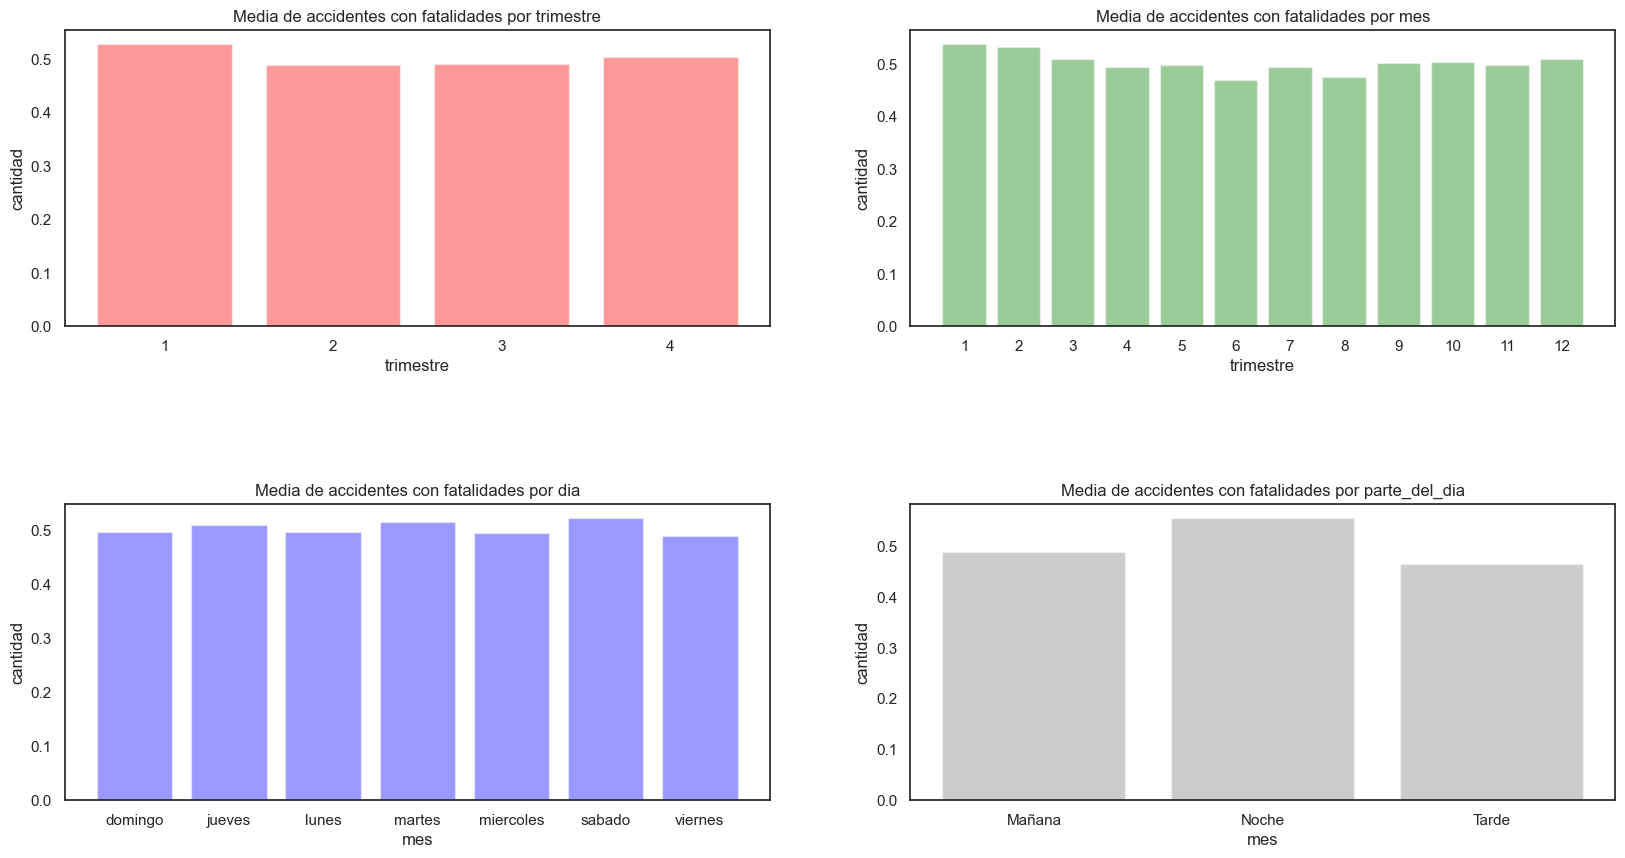

In [25]:
eje_x = []
eje_y = []

cols = ['trimestre', 'mes', 'dia', 'parte_del_dia']
for c in cols:
    grouped = data.groupby(c)
    # numero total de accidentes con victimas segun trimestre/dia
    victimas = grouped.victimas.mean()
    eje_y.append(victimas.values)
    eje_x.append(victimas.index)

color = ['red', 'green', 'blue', 'grey']
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

k = 0
for i in range(2):
    for j in range(2):
        ax[i][j].bar(x=eje_x[k], height=eje_y[k], color=color[k], alpha=0.4)
        ax[i][j].set_xlabel(cols[i])
        ax[i][j].set_ylabel('cantidad')
        ax[i][j].set_title(f'Media de accidentes con fatalidades por {cols[k]}')
        k += 1
        
plt.subplots_adjust(wspace=0.2, hspace=0.6)

ax[0][0].set_xticks(range(1, 5))
ax[0][1].set_xticks(range(1, 13))
plt.show()

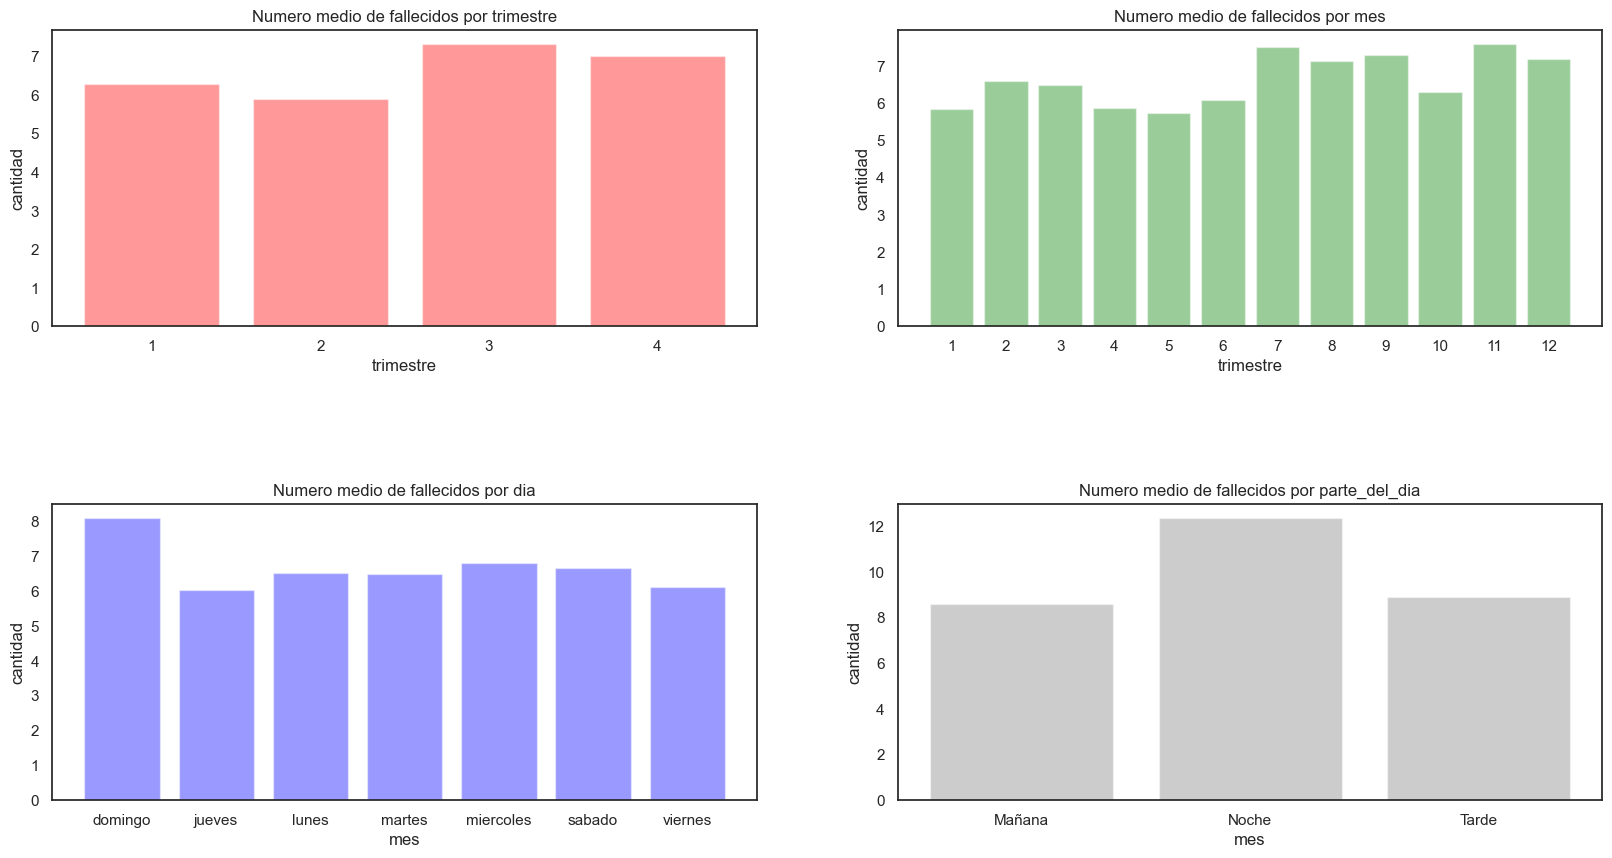

In [26]:
eje_x = []
eje_y = []

cols = ['trimestre', 'mes', 'dia', 'parte_del_dia']
for c in cols:
    grouped = data.groupby(c)
    # numero total de accidentes con victimas segun trimestre/dia
    total_fallecidos = grouped.total_fallecidos.mean()
    eje_y.append(total_fallecidos.values)
    eje_x.append(total_fallecidos.index)
    
color = ['red', 'green', 'blue', 'grey']
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
k = 0
for i in range(2):
    for j in range(2):
        ax[i][j].bar(x=eje_x[k], height=eje_y[k], color=color[k], alpha=0.4)
        ax[i][j].set_xlabel(cols[i])
        ax[i][j].set_ylabel('cantidad')
        ax[i][j].set_title(f'Numero medio de fallecidos por {cols[k]}')
        k += 1

plt.subplots_adjust(wspace=0.2, hspace=0.6)    
 
ax[0][0].set_xticks(range(1, 5))
ax[0][1].set_xticks(range(1, 13))
plt.show()

No vemos ningun patron de estacionalidad a nivel trimestral ni a nivel diario del numero de accidentes con victimas.

A nivel mensual existe un pico en el mes de enero de accidentes con fatalidades, pero esto se debe al tipo de imputacion de datos faltantes realizado en el ETL. Para aquellas fechas con mes/dia faltantes, le hemos imputado el valor de 01-01. Por lo que no hay evidencias significativas de estacionalidad.

Por otro lado, si observamos un pico de aumento de accidentes a la noche, relativo a la maniana y tarde.

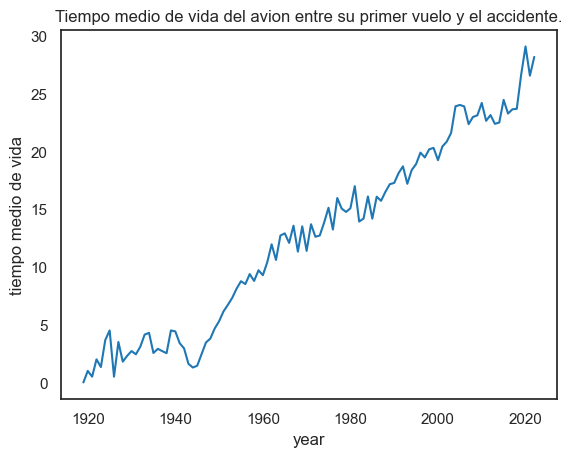

In [27]:
ax = data.groupby('year').edad_avion.mean().plot()
ax.set_title('Tiempo medio de vida del avion entre su primer vuelo y el accidente.')
ax.set_ylabel('tiempo medio de vida')
plt.show()

Este ultimo grafico me parece sumamente interesante.

La edad media de vida entre el primer vuelo y su accidente fue en aumento. Esto podria reflejar en una mejor manufactura en el diseño de las aeronaves.

Veamos ahora la relacion de datos entre años.

In [28]:
from pandas.plotting import autocorrelation_plot

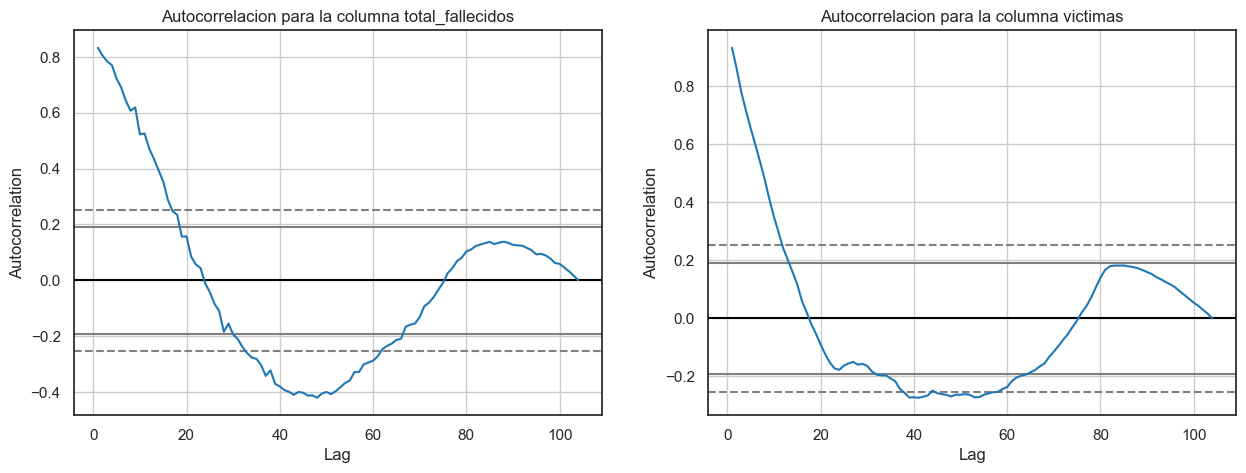

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

c = ['total_fallecidos', 'victimas']

for i in range(2):
    eje_y = year_grouped[c[i]].sum()
    autocorrelation_plot(eje_y.values, ax=ax[i])
    ax[i].set_title(f'Autocorrelacion para la columna {c[i]}')

La lineas horizontales refieren a los limites del intervalo de confianza.

El grafico parece indicar que el numero de fallecidos y de accidentes con fatalidades estarian correlacionados dentro de la misma decada.

Antes de terminar con la parte temporal, veamos algunas metricas:

In [30]:
# Numero medio de la media de personas, pasajeros, y tripulantes fallecidos por anio/mensual.
cols = ['total_fallecidos', 'pasajeros_fallecidos', 'tripulantes_fallecidos']

for c in  cols:
    x = np.mean(year_grouped[c].mean())
    print(f'Media de {c} por anio: {x:.1f}')

print()
month_grouped = data.groupby('mes')
for c in  cols:
    x = np.mean(month_grouped[c].mean())
    print(f'Media de {c} a nivel mensual: {x:.1f}')

Media de total_fallecidos por anio: 5.9
Media de pasajeros_fallecidos por anio: 4.4
Media de tripulantes_fallecidos por anio: 1.5

Media de total_fallecidos a nivel mensual: 6.6
Media de pasajeros_fallecidos a nivel mensual: 5.1
Media de tripulantes_fallecidos a nivel mensual: 1.6


In [31]:
temporal = data.year.value_counts().sort_values(ascending=False)
print(f'{temporal.index[0]} fue el anio con mayor accidentes con un total de {temporal.values[0]}')

temporal = data.groupby('year').victimas.sum().sort_values(ascending=False)
print(f'{temporal.index[0]} fue el anio con mayor accidentes (con fatalidad) con un total de {temporal.values[0]}')

temporal = data.groupby('year').total_fallecidos.sum().sort_values(ascending=False)
print(f'{temporal.index[0]} fue el anio con mayor fallecidos con un total de {temporal.values[0]}')

1970 fue el anio con mayor accidentes con un total de 290
1944 fue el anio con mayor accidentes (con fatalidad) con un total de 252
1985 fue el anio con mayor fallecidos con un total de 2686.0


##### CONCLUSION

Concluimos:

1. Existe una tendencia decreciente en los ultimos anios del numero de accidentes con victimas fatales y el numero de fallecidos.

2. No se observa un patron de estacionalidad a nivel trimestral, mensual o diario.

3. Se observa una correlacion entre los accidentes de la misma decada.

4. La media de fallecidos en accidentes por anio es de 5.9.

5. La media de fallecidos en accidentes por mes es de 6.6.

6. La edad media de vida de la aeronave que sufrio el accidente esta en aumento.

<hr>

#### ANALISIS DESCRIPTIVO

**PREGUNTAS QUE NOS QUERRIAMOS RESPONDER**

- Conocer las caracteristicas mas comunes en los accidentes aereos.

- Entender cuales son los paises que mas sufren esta problematica.

El grafico de abajo corresponde a todos los accidentes, aquellos que incluyen muertos como los que no.

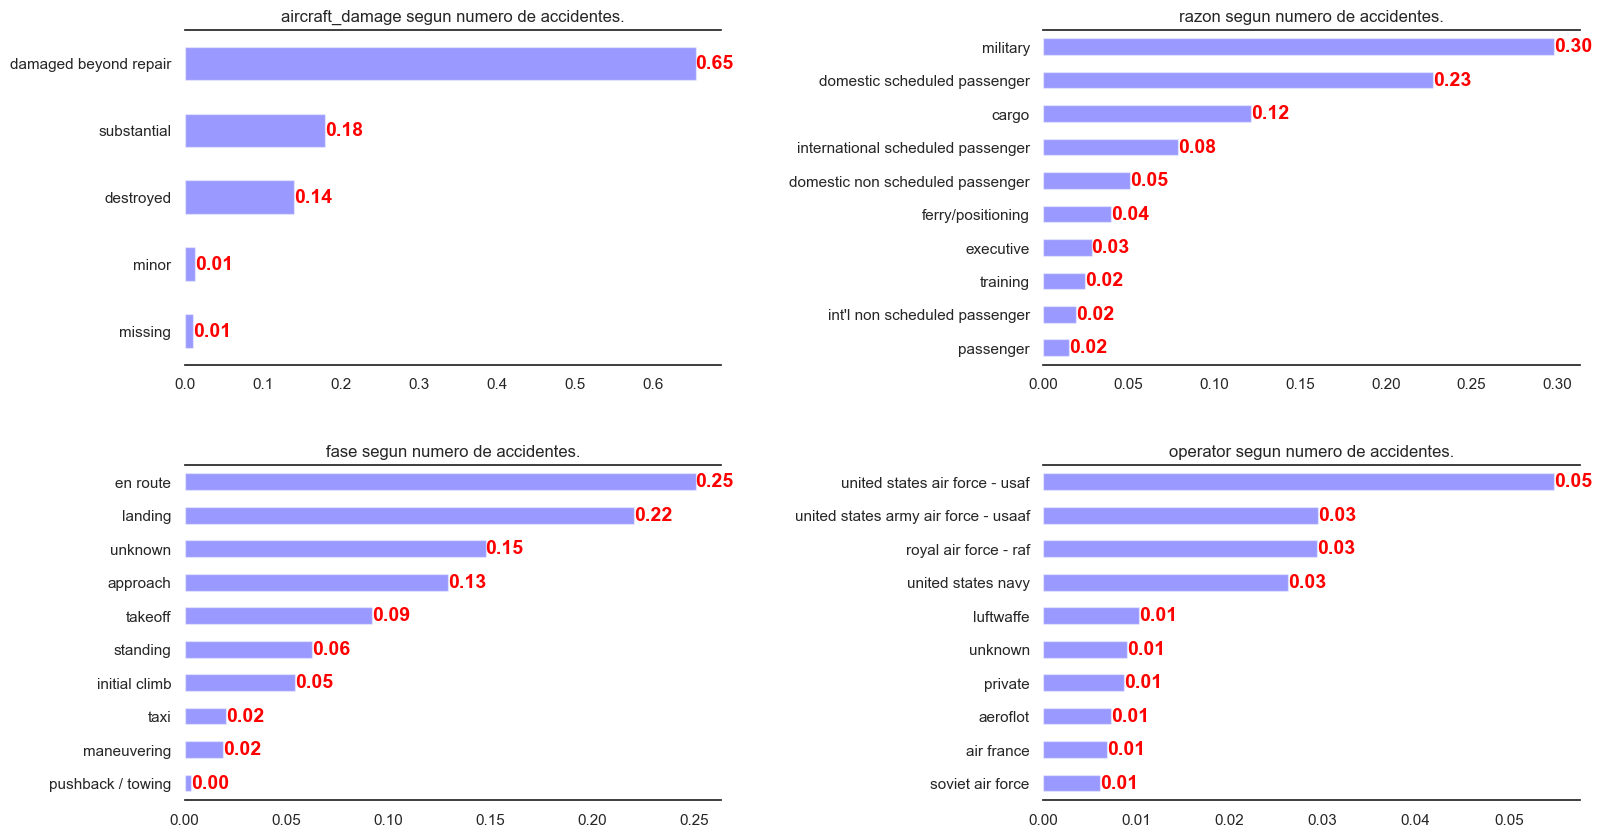

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(18, 10))
plt.subplots_adjust(wspace=0.6, hspace=0.3)    
k = 0

columnas = ['aircraft_damage', 'razon', 'fase', 'operator']
for i in range(2):
    for j in range(2):
        col = columnas[k]
        to_plot = data[col].value_counts(normalize=True).sort_values(ascending=True).tail(10)
        to_plot.plot(kind='barh', color='blue', alpha=0.4, ax=ax[i][j])
        ax[i][j].set_ylabel('')
        
        ax[i][j].set_title(f'{col} segun numero de accidentes.')
        
        # Eliminar bordes derecho e izquierdo
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].spines['left'].set_visible(False)

        # Agregar etiquetas con los valores a las barras
        for w, v in enumerate(data[col].value_counts(normalize=True).sort_values(ascending=True).tail(10)):
            ax[i][j].text(v, w, f'{v:.2f}', va='center', fontweight='bold', fontsize=14, color='red')
            
        # Avanzamos a la proxima columna
        k = k + 1
        

        
plt.show()

Observamos que en un 65% de los accidentes, el daño de la aeronave no se pudo reparar.

El 30% de los accidentes implicaban un tipo de vuelo militar. Por otro lado, los vuelos regulares dentro de un pais con pasajeros forman parte del 23%.

Natualmente, la mayor parte de los operadores eran de caracter militar. 

- Sera por falta de educacion
- Por estar en periodo de guerra
- Por facilidad de acceso
- O por vuelos con naves de prototipo?

Por otro lado, este grafico de abajo corresponde a todos los accidentes que incluyen muertos.

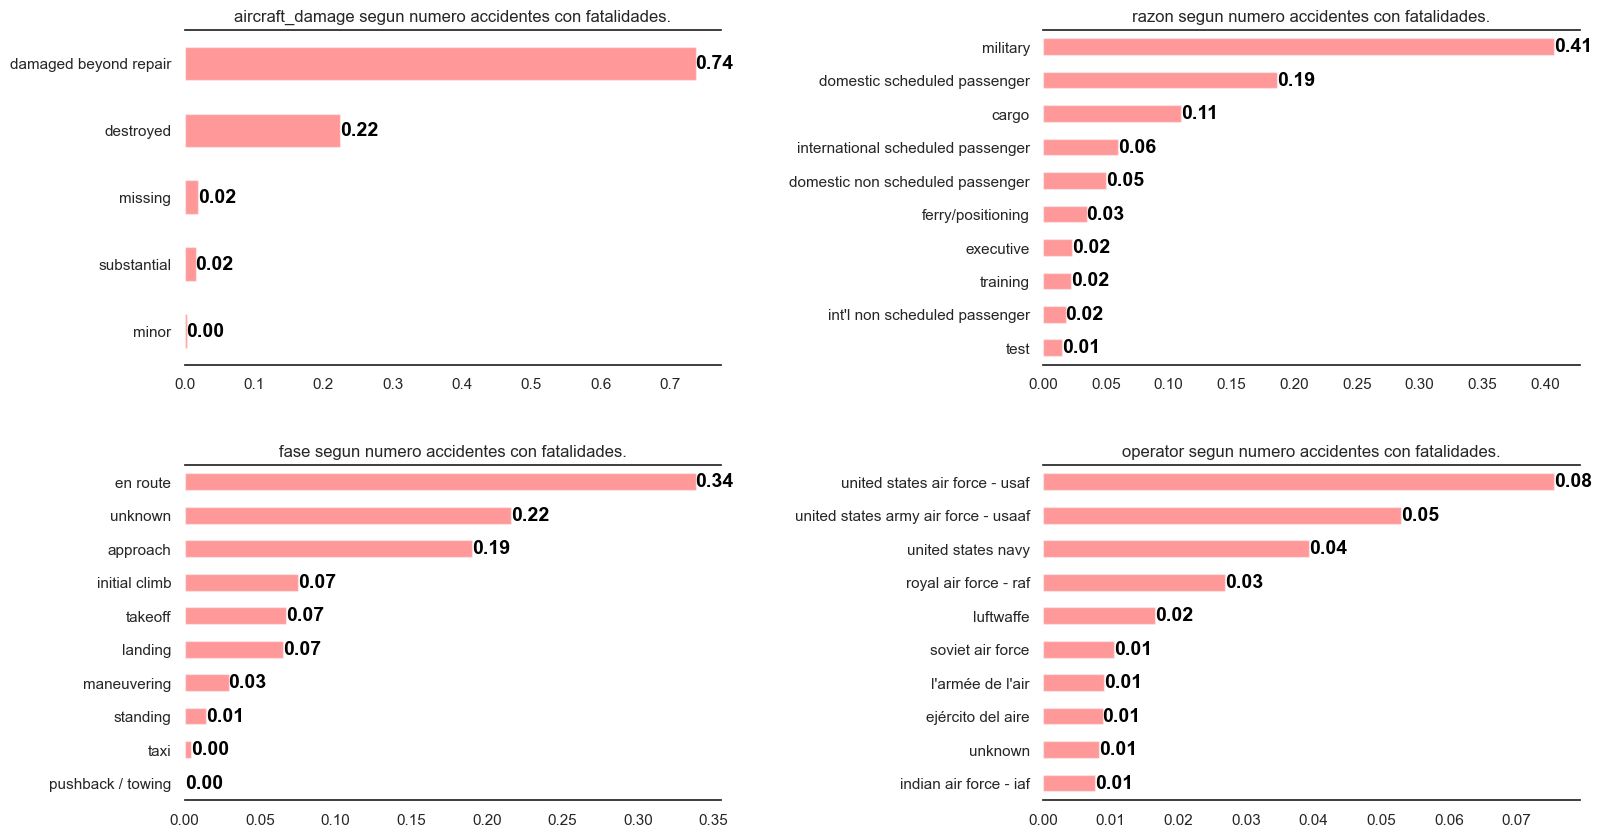

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(18, 10))
plt.subplots_adjust(wspace=0.6, hspace=0.3)    
k = 0

columnas = ['aircraft_damage', 'razon', 'fase', 'operator']
for i in range(2):
    for j in range(2):
        col = columnas[k]
        to_plot = data[data.victimas == True][col].value_counts(normalize=True).sort_values(ascending=True).tail(10)
        to_plot.plot(kind='barh', color='red', alpha=0.4, ax=ax[i][j])
        ax[i][j].set_ylabel('')
        
        ax[i][j].set_title(f'{col} segun numero accidentes con fatalidades.')
        
        # Eliminar bordes derecho e izquierdo
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].spines['left'].set_visible(False)

        # Agregar etiquetas con los valores a las barras
        for w, v in enumerate(data[data.victimas == True][col].value_counts(normalize=True).sort_values(ascending=True).tail(10)):
            ax[i][j].text(v, w, f'{v:.2f}', va='center', fontweight='bold', fontsize=14, color='black')
            
        # Avanzamos a la proxima columna
        k = k + 1
        
plt.show()

**Pequeño resumen hasta aqui**

Lo que se acabo de observar es el tipo de daño, el tipo de vuelo, y la fase en el vuelo de la aeronave que sufrio el accidente.

Esta informacion nos permite entender bien a que tipo de accidentes aereos nos enfrentamos y en donde debemos primar el esfuerzo para reducirlos.

**ANALICEMOS LA UBICACION DE LOS ACCIDENTES**

In [34]:
from collections import Counter
from wordcloud import WordCloud

# Esta funcion crea la nube de palabras.

def wordcloud_im(token_counter, title):
    
    # Crear el objeto WordCloud
    wordcloud = WordCloud(width=800, height=400, font_path='../roboto_med.ttf').generate_from_frequencies(token_counter)
    
    wordcloud = wordcloud.recolor(colormap='Pastel1_r')
    wordcloud.background_color = 'black'
    wordcloud.max_font_size = 40

    # Mostrar el wordcloud en un gráfico
    plt.figure(figsize=(20, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20, fontweight='bold')
    plt.axis('off')
    
    # Centrar la nube de palabras en el gráfico
    fig.tight_layout()
    
    plt.show()

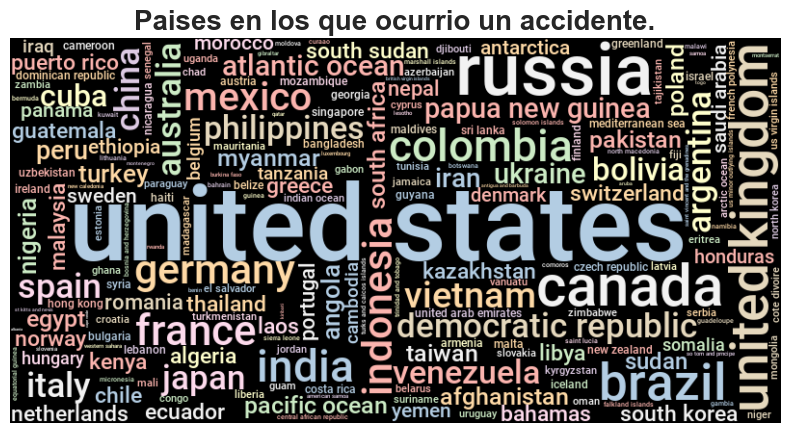

In [35]:
notna = data.pais_accidente.notna()
paises = Counter(data.loc[notna, 'pais_accidente'].tolist())

wordcloud_im(paises, 'Paises en los que ocurrio un accidente.')

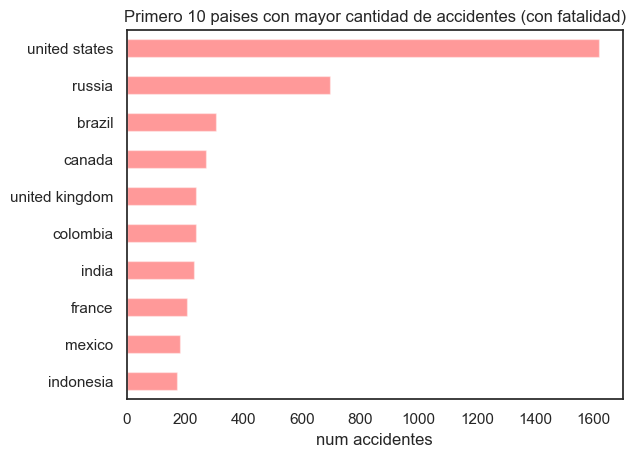

In [36]:
y = data.groupby('pais_accidente').victimas.sum().sort_values(ascending=True).tail(10)
ax = y.plot(kind='barh', color='red', alpha=0.4)
ax.set_ylabel('')
ax.set_xlabel('num accidentes')
ax.set_title('Primero 10 paises con mayor cantidad de accidentes (con fatalidad)')
plt.show()

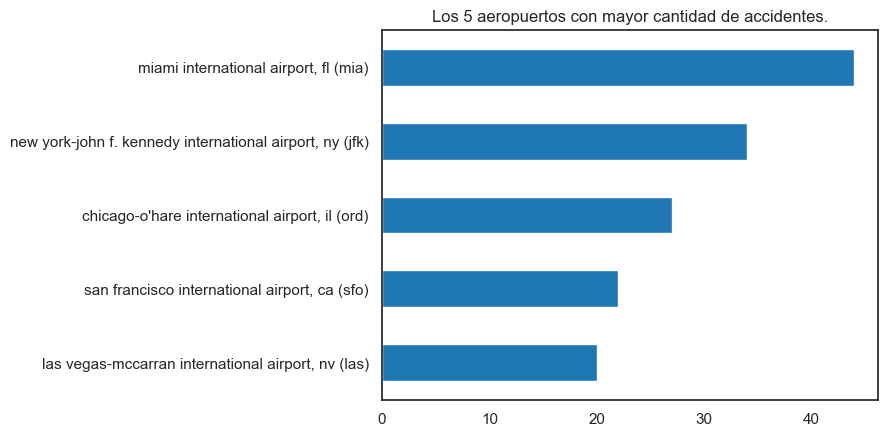

In [39]:
indice = data.pais_accidente == 'united states'
ax = data.loc[indice, 'estado_accidente'].value_counts().sort_values(ascending=True).tail(5).plot(kind='barh')
ax.set_ylabel('')
ax.set_title('Los 5 aeropuertos con mayor cantidad de accidentes.')
plt.show()

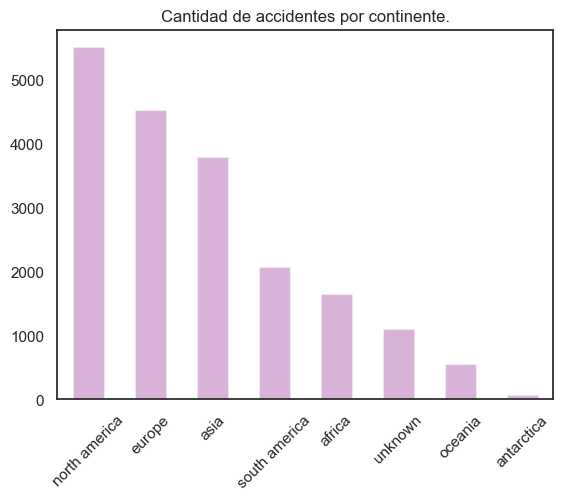

In [40]:
ax = data.continente.value_counts().plot(kind='bar', color='purple', alpha=0.3)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('Cantidad de accidentes por continente.')
plt.show()

Estados unidos es el pais con mayor numero de accidentes con y sin fatalidad.

Y vemos que en miami international airport es donde ocurrieron mas accidentes.

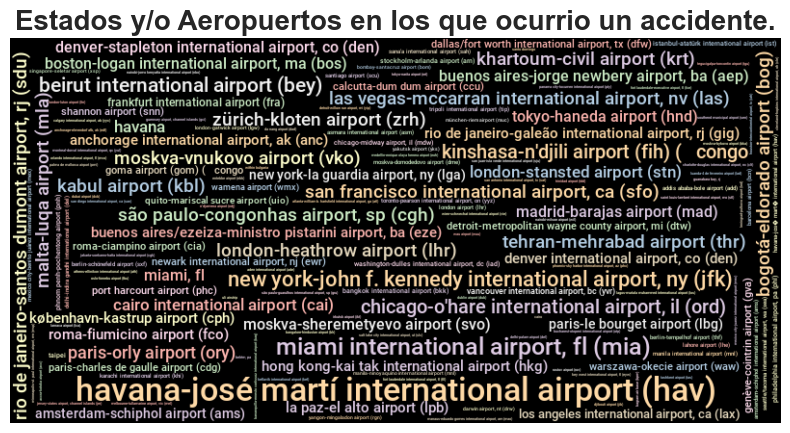

In [41]:
notna = data.estado_accidente.notna()
estados = Counter(data.loc[notna, 'estado_accidente'].tolist())

wordcloud_im(estados, 'Estados y/o Aeropuertos en los que ocurrio un accidente.')

Estos ultimos graficos nos proveen de una visualizacion rapida de:

- Los distintos paises y sus frecuencias, que estan involucrados en accidentes.

- Los estados/aeropuertos mas comunes en los que ocurrio el accidente.

- Las rutas de estado de salida y destino mas comunes.

- La cantidad de accidentes por continentes.

**ANALISIS DE PALABRAS CLAVES EN NARRATIVE**

Narrative es una pequenia descripcion realizada sobre el accidente. En el se explican causas, razones del suceso.

Abajo vera un wordcloud a partir de las columnas top3_(n)gram.

Cada wordcloud mostrara cuales fueron aquellas palabras mas frecuentes a la hora de describir o narrar el accidente.

Junto con un barplot que graficara los 10 token mas frecuentes en todo el dataset.

In [42]:
def bar_ngram(token_counter, title):
    
    top_tokens = dict(token_counter.most_common(10))
    tokens = list(top_tokens.keys())
    frequencies = list(top_tokens.values())
    y_pos = np.arange(len(tokens))
    
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.barh(y_pos, frequencies, align='center', color='orange')
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(tokens)
    ax.invert_yaxis()
    ax.set_xlabel('Frecuencia')
    ax.set_title(f'TOP 10 {title}')
    
    plt.show()

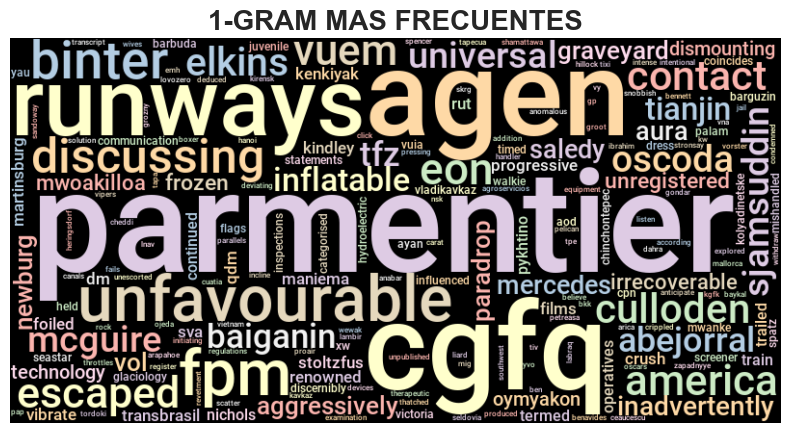

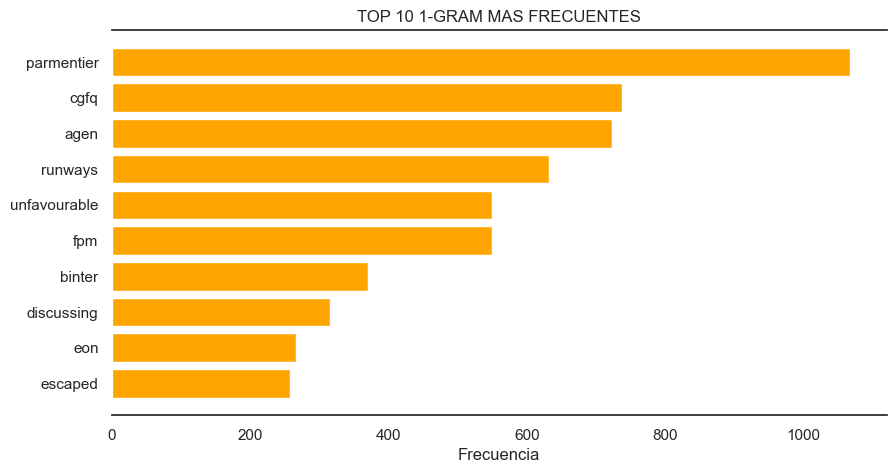

In [43]:
texto = ' '.join([x.replace(' ', '_').replace('|', ' ') for x in data.top3_1gram.tolist()])
token_counter = Counter(texto.split(' '))
title = '1-GRAM MAS FRECUENTES'

wordcloud_im(token_counter, title)
bar_ngram(token_counter, title)

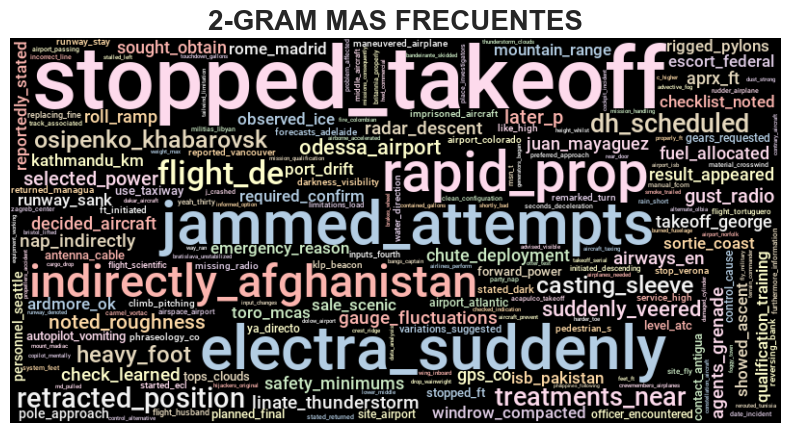

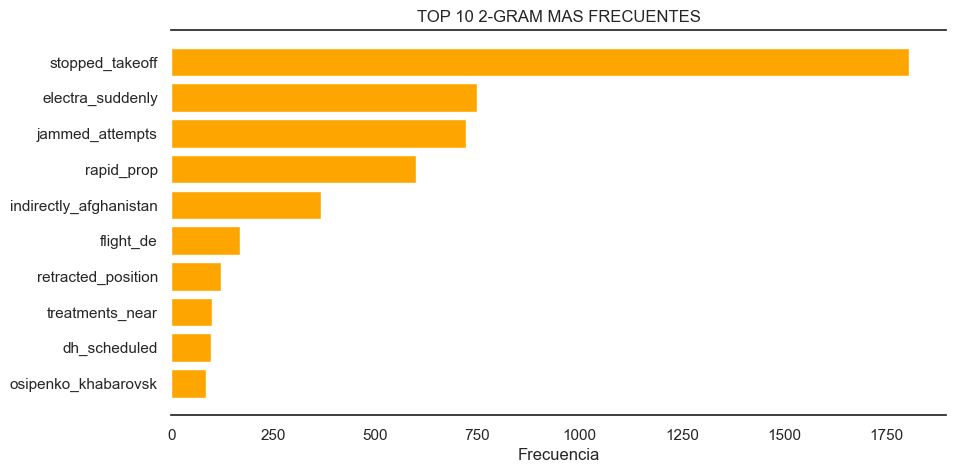

In [44]:
texto = ' '.join([x.replace(' ', '_').replace('|', ' ') for x in data.top3_2gram.tolist()])
token_counter = Counter(texto.split(' '))
title = '2-GRAM MAS FRECUENTES'

wordcloud_im(token_counter, title)
bar_ngram(token_counter, title)

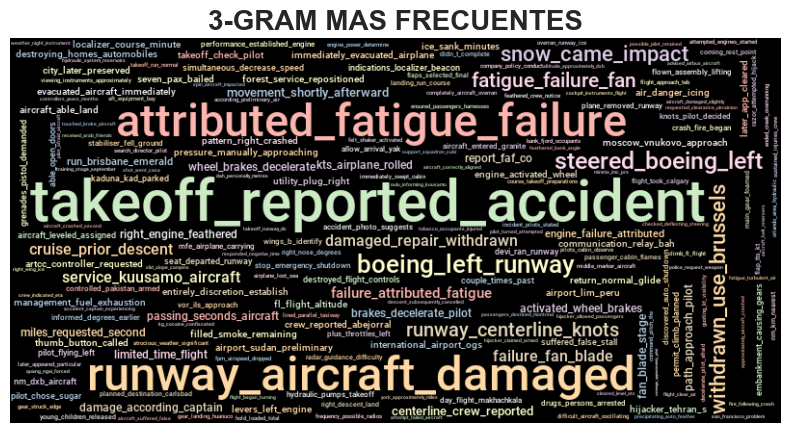

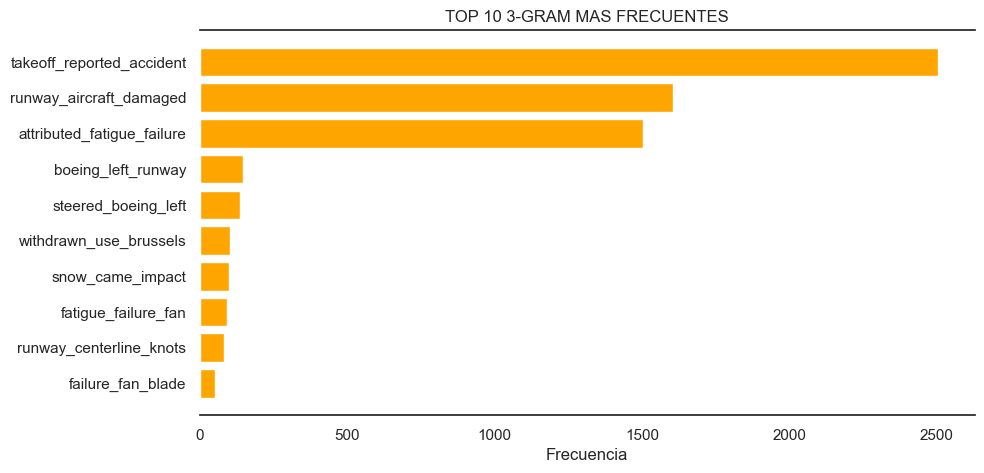

In [45]:
texto = ' '.join([x.replace(' ', '_').replace('|', ' ') for x in data.top3_3gram.tolist()])
token_counter = Counter(texto.split(' '))
title = '3-GRAM MAS FRECUENTES'

wordcloud_im(token_counter, title)
bar_ngram(token_counter, title)

### CONCLUSION DEL EDA

A modo de conclusion, resumamos las observaciones que notamos:

1. El numero de accidentes no muestra un decaimiento significativo con el tiempo.
2. Sin embargo, si! decayo respecto durante los ultimos anios el numero de accidentes con victimas fatales.
3. La mayor parte de los accidentes ocurrieron en el pais de Estados Unidos, en el aeropuerto de Miami.
4. Las razones de vuelo de la mayor parte de accidente son de tipo militar, traslado de pasajeros, y traslado de mercaderia (cargo).
5. En la mayor parte de los accidentes, las aeronaves quedaron completamente destruidas sin capacidad de reparacion.
6. No se observo ningun patron de estacionalidad a nivel trimestral, mensual, diario, u horario/parte del dia.
7. La distancia de anios entre el primer vuelo y el accidente de los aviones fue en aumento con el tiempo.

<hr>

## FINAL

Por ultimo, almacenemos nuestro nuevo dataframe para ser usado por un dashboard interactivo.

In [46]:
data.shape

(19253, 40)

In [47]:
data.to_csv('../../data/transform/asn_final_eda.csv', header=True, index=False, sep=',', mode='w')